<a href="https://colab.research.google.com/github/lukeirwin03/MNIST-Convolutional-Neural-Network/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy

import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

import requests
from PIL import Image
from io import BytesIO

In [ ]:
numb_batch = 64

# Getting Data

In [ ]:
T = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



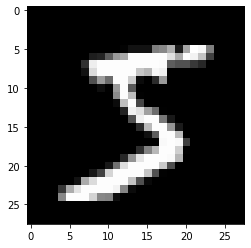

In [ ]:
plt.imshow(train_data[0][0][0], cmap="gray")

# Create the Model

In [ ]:
def create_lenet():
  model = nn.Sequential(
      
      nn.Conv2d(1, 6, 5, padding=2),
      nn.ReLU(),
      nn.AvgPool2d(2, stride=2),

      nn.Conv2d(6, 16, 5, padding=0),
      nn.ReLU(),
      nn.AvgPool2d(2, stride=2),

      nn.Flatten(),
      # channels * kernel_size^2 = 16 * 5 * 5 = 400
      nn.Linear(400 , 120), 
      nn.ReLU(),
      nn.Linear(120 , 84),
      nn.ReLU(),
      nn.Linear(84 , 10)

  )

  return model

# Validate the Model

In [ ]:
def validate(model, data):
  total = 0
  correct = 0
  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x, 1)
    pred = pred.data.cpu()
    total += x.size(0)
    correct += torch.sum(pred == labels)

  return correct * 100. / total

# Training Function

In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
  accuracies = []
  cnn = create_lenet().to(device)
  cec = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn.parameters(), lr=lr)
  max_accuracy = 0

  for epoch in range(numb_epoch):
    for i, (images, labels) in enumerate(train_dl):
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      pred = cnn(images)
      loss = cec(pred, labels)
      loss.backward()
      optimizer.step()
    accuracy = float(validate(cnn, val_dl))
    accuracies.append(accuracy)
    print("Epoch: ", epoch+1, "Accuracy: ", accuracy,"%")
    if(accuracy > max_accuracy):
      best_model = copy.deepcopy(cnn)
      max_accuracy = accuracy
      print("Saving Best Model with Accuracy: ", accuracy)
  print(accuracies)
  plt.plot(accuracies)
  return best_model

# GPU Availability

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# Training the Model

Saving Best Model with Accuracy:  95.4000015258789
Epoch:  1 Accuracy:  95.4000015258789 %
Saving Best Model with Accuracy:  96.94000244140625
Epoch:  2 Accuracy:  96.94000244140625 %
Saving Best Model with Accuracy:  97.68000030517578
Epoch:  3 Accuracy:  97.68000030517578 %
Saving Best Model with Accuracy:  97.97000122070312
Epoch:  4 Accuracy:  97.97000122070312 %
Saving Best Model with Accuracy:  98.41999816894531
Epoch:  5 Accuracy:  98.41999816894531 %
Saving Best Model with Accuracy:  98.62999725341797
Epoch:  6 Accuracy:  98.62999725341797 %
Epoch:  7 Accuracy:  98.62999725341797 %
Saving Best Model with Accuracy:  98.76000213623047
Epoch:  8 Accuracy:  98.76000213623047 %
Epoch:  9 Accuracy:  98.63999938964844 %
Saving Best Model with Accuracy:  98.80000305175781
Epoch:  10 Accuracy:  98.80000305175781 %
Epoch:  11 Accuracy:  98.47000122070312 %
Epoch:  12 Accuracy:  98.75 %
Epoch:  13 Accuracy:  98.55000305175781 %
Epoch:  14 Accuracy:  98.66999816894531 %
Epoch:  15 Accuracy

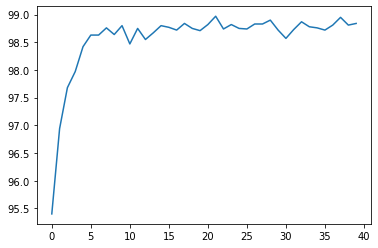

In [ ]:
lenet = train(40, device=device)

In [ ]:
def predict_dl(model, data):
  y_pred = []
  y_true = []
  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x, 1)
    pred = pred.data.cpu()
    y_pred.extend(list(pred.numpy()))
    y_true.extend(list(labels.numpy()))
  return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,978,0,0,0,0,0,0,1,1,0
1,0,1131,0,0,0,0,2,0,1,1
2,4,1,1023,1,1,0,0,2,0,0
3,0,0,0,1000,0,3,0,4,2,1
4,0,0,1,0,972,0,3,1,0,5
5,2,1,0,5,0,880,1,0,0,3
6,3,2,1,0,0,6,945,0,1,0
7,1,3,3,0,0,0,0,1017,2,2
8,3,0,2,2,1,3,0,2,959,2
9,0,0,0,0,5,5,2,1,4,992


# Define Inference Function

In [ ]:
def inference(path, model, device):
  r = requests.get(path)
  with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28,28))
    img_mat = (255 - np.expand_dims(np.array(img), -1)) /255.
  with torch.no_grad():
    pred = model(torch.unsqueeze(T(img_mat), axis=0).float().to(device))
    return F.softmax(pred, dim=-1).cpu().numpy()

In [ ]:
path = 'https://st.depositphotos.com/2899123/3753/v/950/depositphotos_37531945-stock-illustration-5-black-handwritten-number-on.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
  img = Image.open(f).convert(mode="L")
  img = img.resize((28,28))
  img_mat = (255 - np.expand_dims(np.array(img), -1)) /255.

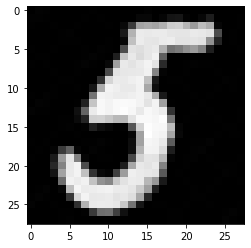

In [ ]:
plt.imshow(img_mat.squeeze(-1), cmap="gray")

# Predictions

In [ ]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f'Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %')

Predicted: 5, Prob: 84.00849103927612 %


In [ ]:
pred

array([[2.3101115e-13, 2.1266775e-09, 2.2468242e-08, 1.5460525e-01,
        1.4118058e-06, 8.4008491e-01, 1.7102328e-12, 8.5366723e-13,
        5.2735368e-03, 3.4836703e-05]], dtype=float32)

# Source





Author: Krishna Ramesh

Links: 


*   Youtube: https://www.youtube.com/watch?v=ijaT8HuCtIY
*   Blog: https://medium.com/@krishna.ramesh.tx/training-a-cnn-to-distinguish-between-mnist-digits-using-pytorch-620f06aa9ffa